In [19]:
!pip install -q torchaudio omegaconf soundfile

In [3]:
import torch
import pandas as pd
import numpy as np
import torchaudio
import requests
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import librosa
import librosa.display
import IPython
import IPython.display as ipd  # To play sound in the notebook
import os
import zipfile
import os
import cv2
import wave, struct
import string
import requests
import torch.nn as nn
import torchaudio

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim as optim, functional as F
from IPython.display import Audio, display
from glob import glob
from PIL import Image
from torchvision.transforms import ToTensor
from torch.nn.utils.rnn import pad_sequence

device = torch.device('cpu')

# AUTOMATIC SPEECH RECOG SECTION

In [4]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

## MFCC for ASR  -> ERROR IN PREPROCESSING DATA

In [6]:
##1. Convert Audio Samples to MFCCs -> Use this for ASR and Sentiment Analysis Models
waveform_init, sample_rate_init, utterance_init, _, _, _ = train_dataset[0]

transformations_spectrogram = torchaudio.transforms.Spectrogram(normalized=True)
transformations_mel_spec = nn.Sequential(torchaudio.transforms.MelSpectrogram(n_mels = 128, sample_rate = sample_rate_init), 
                                         torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
                                         torchaudio.transforms.TimeMasking(time_mask_param=100)
                                        )
transformations_mfcc = torchaudio.transforms.MFCC(n_mfcc = 40, sample_rate = sample_rate_init)

numbers = [i for i in range(0, 28)]
characters = list(string.ascii_lowercase)
characters.insert(0, ' ')
characters.insert(0, "'")
char_int_map = dict(zip(characters, numbers))

def text_to_int(utterance):
    int_sequence = []
    for i in list(utterance.lower()):
        template_append = char_int_map[i]
        int_sequence.append(template_append)
    return torch.FloatTensor(int_sequence)

def data_preprocessing(data, transform_type): 
    spectrogram_transform = []
    label = []
    input_lengths = []
    label_lengths = []
    for waveform, sample_rate, utterance, _, _, _ in data:
        spec_transform = transform_type(waveform).squeeze()
        new_label = text_to_int(utterance)
        label.append(new_label)
        spectrogram_transform.append(spec_transform)
        input_lengths.append(spec_transform.shape[0]//2)
        label_lengths.append(len(label))
    label = pad_sequence(label)
    return spectrogram_transform, label, input_lengths, label_lengths

def mel_spectrogram_visualizer(data, sr, label, transform_type):
    fig, ax = plt.subplots()
    
    if transform_type == transformations_mel_spec:
        to_decibels = librosa.power_to_db(data.numpy(), ref=np.max)
        img = librosa.display.specshow(to_decibels, x_axis='time', y_axis='mel', sr=sr, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title=label)
    else:
        print("ERROR:")

mel_train_dataset = data_preprocessing(train_dataset, transformations_mel_spec)
mel_valid_dataset = data_preprocessing(test_dataset, transformations_mel_spec)

In [7]:
print(mel_train_dataset[0][0].shape)

torch.Size([128, 1163])


/Users/devpatelio/miniconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/devpatelio/miniconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


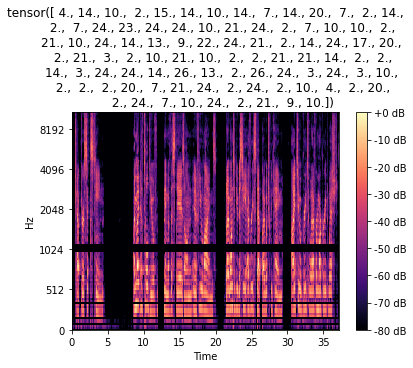

In [8]:
##2. Setup Training and Preprocessing
mel_spectrogram_visualizer(mel_train_dataset[0][0], sample_rate_init, mel_train_dataset[1][0], transformations_mel_spec)
train_loader = torch.utils.data.DataLoader(mel_train_dataset, shuffle=True, batch_size=20)
val_loader = torch.utils.data.DataLoader(mel_valid_dataset, shuffle=False, batch_size=20)

## DeepSpeech2 in PyTorch Adaptation for ASR 

In [9]:
#Thanks to https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch for providing in-depth explanations in code for the D2S model

#1. Adapt model architecture from https://arxiv.org/pdf/1512.02595.pdf
#2. Start with GRU
#3. Next with ResCNN
#4. Make Single Classifier

class GRUBlock(nn.Module):
    def __init__ (self, audio_dim, hidden_dim, dropout, num_layers = 1):
        super(GRUBlock, self).__init__()
        self.hidden_size = hidden_dim
        self.layernorm = nn.LayerNorm(audio_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.gru = nn.GRU(audio_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True) #x = batch_size, sequence, feature

        
    def forward(self, x, hidden_dim):
        hidden_init = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out = x.transpose(2, 3).contiguous()
        out = self.layernorm(out)
        out = out.transpose(2, 3).contiguous()
        out, _ = self.gru(out, hidden_init) #output = batch_size, sequence, hidden_dim
        out = self.dropout(out)
        return out
    
    
    
class ResBlock(nn.Module):
    def __init__ (self, input_channels, output_channels, feature_no, dropout):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels, feature_no, padding=1, bias=False)
        self.conv2 = nn.Conv2d(output_channels, output_channels, feature_no, padding=1, bias=False)
        self.layernorm = nn.LayerNorm(feature_no)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu') #initialization comes from ResNet Paper
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu') #initialization comes from ResNet Paper
        nn.init.constant_(self.layernorm.weight, 0.5)
        nn.init.zeros_(self.layernorm.bias)
        
    def forward(self, x):
        residual = x
        out = x.transpose(2, 3).contiguous()
        out = self.layernorm(out)
        out = out.transpose(2, 3).contiguous()
        out = nn.ReLU(out)
        out = self.dropout1(out)
        out = self.conv1(x)
        
        out = x.transpose(2, 3).contiguous()
        out = self.layernorm(out)
        out = out.transpose(2, 3).contiguous()
        out = nn.ReLU(out)
        out = self.dropout2(out)
        out = self.conv2(x)
        out += residual
        return out

    
class ASRModel(nn.Module):
    def __init__ (self, n_gru_layers, n_cnn_layers, audio_dim, hidden_dim, n_classes, feature_no):
        super(ASRModel, self).__init__()
        feature_no = feature_no//2
        
        #order
        self.cnn_first = nn.Conv2d(1, 32, 3, stride=2, padding=3//2)
        self.resblocks = nn.Sequential(* (n_cnn_layers * [ResBlock(input_channels = 32, output_channels = 32, dropout=0.1, feature_no = feature_no)]))
        self.middle_connector = nn.Linear(feature_no * 32, audio_dim)
        self.grublocks = nn.Sequential(* (n_gru_layers * [GRUBlock(audio_dim=audio_dim, hidden_dim=hidden_dim, dropout=0.1)]))
        
        self.classifier = nn.Sequential(nn.Linear(audio_dim*2, audio_dim), 
                                        nn.ReLU(), 
                                        nn.Dropout(0.1),
                                        nn.Linear(audio_dim, n_classes)
                                    )
        
    def forward(self, x):
        output = self.cnn_first(x)
        output = self.resblocks(output)
        sizes = x.size()
        output = output.view(sizes[0], sizes[1]*sizes[2], sizes[3])
        output = output.transpose(1, 2)
        output = self.middle_connector(output)
        output = self.grublocks(output)
        output = self.classifier(output)
        return output
    




## Preprocess Training Data -> TURN LANDMARK GENERATION INTO FUNCTION

In [10]:
print(cv2.__version__)
!kaggle datasets download -d chiragsoni/ferdata

4.5.1
ferdata.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#1. Dataset class
import torchvision.transforms as transforms

label_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
one_hot_template = torch.zeros(len(label_names), len(label_names))

for i in range(0, len(label_names)):
    one_hot_template[i][i] = 1

label_encoder_dict = {label_names[i]: one_hot_template[i] for i in range(0, len(label_names))}
    
class FacialImages(Dataset):
    def __init__(self, directory, label_directory_names):
        loader = os.listdir(str(directory))
        labels = label_directory_names
        self.dataset = []
        final_labelled_directories = []
        self.transform = transforms.Compose([transforms.ToTensor()])
        loader.remove(loader[1])

        for counter, i in enumerate(loader):
            final_labelled_directories.append([directory + '/' + i, i])

        for i, g in final_labelled_directories:
            label_loader = os.listdir(i)
            for x in label_loader:
                if x == '.ipynb_checkpoints': 
                    continue
                with Image.open(i +'/' + x) as image:
                    trs_image = self.transform(image.resize((48, 48)))
                    self.dataset.append([trs_image, label_encoder_dict[g], str(i +'/' + x)])
    
    def __len__(self):
        return(len(self.dataset))
    
    def __getitem__(self, index):
        image = self.dataset[index][0]
        label = self.dataset[index][1]
        directory = self.dataset[index][2]
        
        return [image, label, directory]
        
        
    def image_view(self, index):
        array = self.dataset[index][0].view(256, -1)
        return plt.imshow(array.numpy(), cmap='gray'), array

train_data = FacialImages('/Users/devpatelio/Downloads/Coding/Python/pyTorch/conversation_mood/image_mood/ferdata/train', label_names)
test_data = FacialImages('/Users/devpatelio/Downloads/Coding/Python/pyTorch/conversation_mood/image_mood/ferdata/test', label_names)

In [ ]:
#2. Get landmark data
from matplotlib import pyplot as plt, transforms
from imutils import face_utils
import dlib

def list_string(path):
    std = ""
    for i in path:
        std = std+i
        return std
    
def landmark_view(coords):
    x_landmarks = []
    y_landmarks = []
    for i in coords:
        x_landmarks.append(-int(i[0]))
        y_landmarks.append(-int(i[1]))
    plt.scatter(x_landmarks, y_landmarks)
    plt.show()

face_predictor = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor("/Users/devpatelio/Downloads/Coding/Python/pyTorch/conversation_mood/image_mood/shape_predictor_68_face_landmarks.dat")
landmarks_list = []

for x in range(0, len(train_data)):
    path = train_data[x][2]
    label = train_data[x][1]
    img = cv2.resize(cv2.imread(path, 0), (1024, 1024))
    detects = face_predictor(img, 0)

    for (i, detect) in enumerate(detects):
        shape = shape_predictor(img, detect) #image, bounding_box for restriction
        shape = face_utils.shape_to_np(shape)
        
        landmarks_list.append([[(x, y) for (x, y) in shape], label])
    
    if x%1000==0:
        print(x)

for idx, i in enumerate(landmarks_list):
    landmarks_list[idx][0] = torch.FloatTensor(landmarks_list[idx][0])
#     landmarks_list[idx][0] = landmarks_list[idx][0].flatten()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [ ]:
landmarks_list_test = []
for x in range(0, len(test_data)):
    path = test_data[x][2]
    label = test_data[x][1]
    img = cv2.resize(cv2.imread(path, 0), (1024, 1024))
    detects = face_predictor(img, 0)

    for (i, detect) in enumerate(detects):
        shape = shape_predictor(img, detect) #image, bounding_box for restriction
        shape = face_utils.shape_to_np(shape)
        
        landmarks_list_test.append([[(x, y) for (x, y) in shape], label])
    
    if x%100==0:
        print(x)

for idx, i in enumerate(landmarks_list_test):
    landmarks_list_test[idx][0] = torch.FloatTensor(landmarks_list_test[idx][0])
#     landmarks_list_test[idx][0] = landmarks_list_test[idx][0].flatten()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900


In [19]:
#Regularize the data

for idx, i in enumerate(landmarks_list):
    for xdx, x in enumerate(i[0]):
        landmarks_list[idx][0][xdx] = x/255
    

In [ ]:
batch_size = 10
num_epochs = 50

train_landmarks = landmarks_list
test_landmarks = landmarks_list_test

trainloader = torch.utils.data.DataLoader(train_landmarks, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_landmarks, batch_size=batch_size, shuffle=False)


dataiter = iter(trainloader)
data = dataiter.next()

keys = list(label_encoder_dict.keys())
values = list(label_encoder_dict.values())

train_data[155][0].shape

torch.Size([1, 48, 48])

## Sentiment Model for Landmarks

In [586]:
import torch.nn.functional as F

class FeedForward(nn.Module): 
    def __init__(self):
        super(FeedForward, self).__init__() 
        self.fc1 = nn.Linear(68*2, 300)
        self.fc5 = nn.Linear(300, 200)
        self.fc6 = nn.Linear(200, 100)
        self.output = nn.Linear(100, 7)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = F.relu(self.dropout(self.fc1(x)))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = F.relu(self.fc4(x))
        x = F.relu(self.dropout(self.fc5(x)))
        x = F.relu(self.dropout(self.fc6(x)))
        x = self.output(x)
        x = self.softmax(x)
        return x

from torch.optim import Adam, SGD

ff = FeedForward()
optimizer = Adam(ff.parameters())
criterion = nn.CrossEntropyLoss()
print(ff)

train_losses = []
for epoch in range(0, 20):
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs = data[0]
        labels = data[1]
#         inputs = inputs.view(20, -1, 68*2)
        inputs = inputs.squeeze()
        optimizer.zero_grad()
        outputs = ff(inputs)
        labels = torch.squeeze(labels)
#         labels = labels.type(torch.FloatTensor)
        labels = labels.type(torch.LongTensor)
        labels = torch.max(labels, 1)[1]
        loss = criterion(outputs, labels)
        loss = Variable(loss, requires_grad=True)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
#         print(f"Epoch: {epoch} Training loss: {loss}")  

    print(f"Epoch: {epoch} Training loss: {running_loss}")  


print('Finished Training')

plt.plot(train_losses)
plt.show()

FeedForward(
  (fc1): Linear(in_features=136, out_features=300, bias=True)
  (fc5): Linear(in_features=300, out_features=200, bias=True)
  (fc6): Linear(in_features=200, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=7, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.1, inplace=False)
)


## Sentiment Model for Image

In [766]:
class FacialSentiment(nn.Module):
    def __init__ (self):
        super(FacialSentiment, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(5, 5), stride=1) #in, out, kernel, stride
        self.conv1b = nn.BatchNorm2d(64) #output of previous step
        self.pool1 = nn.MaxPool2d(2, 2, padding=1) #kernel, stride
        self.dropout = nn.Dropout(0.4) #0-1 value 
        
        #layer 2
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(5, 5), stride=1) #in, out, kernel, stride
        self.conv2b = nn.BatchNorm2d(64) #output of previous step
        self.pool2 = nn.MaxPool2d(2, 2, padding=1) #kernel, stride
        self.dropout = nn.Dropout(0.5) #0-1 value 
        
        #layer 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1) #in, out, kernel, stride
        self.conv3b = nn.BatchNorm2d(128) #output of previous step
        
        #layer 4
        self.conv4 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=1) #in, out, kernel, stride
        self.conv4b = nn.BatchNorm2d(128) #output of previous step
        self.pool4 = nn.MaxPool2d(2, 2, padding=1) #kernel, stride
        self.dropout = nn.Dropout(0.5) #0-1 value 
        
        #layer 5
        self.conv5 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1) #in, out, kernel, stride
        self.conv5b = nn.BatchNorm2d(256) #output of previous step
        
        self.conv6 = nn.Conv2d(256, 256, kernel_size=(2, 2), stride=1) #in, out, kernel, stride
        self.conv6b = nn.BatchNorm2d(256) #output of previous step
        self.pool6 = nn.MaxPool2d(2, 2, padding=1) #kernel, stride
        self.dropout = nn.Dropout(0.5) #0-1 value
        
        ##fully connected
        self.fc1 = nn.Linear(in_features= 256, out_features=128)
#         self.fcb1 = nn.InstanceNorm1d(128)
        self.fc2 = nn.Linear(in_features = 128, out_features = 7)

        
        self.soft = nn.Softmax(dim=1)
    
        
    def forward(self, x):
        x = F.relu(self.dropout((self.pool1(self.conv1b(self.conv1(x))))))
        x = F.relu(self.dropout((self.pool2(self.conv2b(self.conv2(x))))))
        x = F.relu(self.conv3b(self.conv3(x)))
        x = F.relu(self.dropout((self.pool4(self.conv4b(self.conv4(x))))))
        x = F.relu(self.conv5b(self.conv5(x)))
        x = F.relu(self.dropout((self.pool6(self.conv6b(self.conv6(x))))))
        batch, kernels, length, width = x.shape
        x = x.view(batch, -1)
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.soft(x)
        
        return x
        
print(model)

FacialSentiment(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv1b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=1, inplace=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (co

## Validation and Testing for Facial Sentiment Analysis

In [767]:
print(len(test_data))

5931


In [ ]:
from torch.optim.lr_scheduler import StepLR
import ignite.distributed as idist
from ignite.contrib.engines import common
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine, Events, create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import Accuracy, Loss


train_loader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=False)

model = FacialSentiment()
optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.6)
criterion = nn.CrossEntropyLoss()
epochs = 20


def train_step(engine_loader, optimizer, criterion):
    model.train()
    running_loss = 0
    for i, data in enumerate(engine_loader, 0):
        optimizer.zero_grad()
        inp, label = data[0], data[1]
        output_pred = model(inp)
        loss = criterion(output_pred, torch.max(label, 1)[1])
        loss = Variable(loss, requires_grad=True)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
#         if i%50==0:
#             print(running_loss)
    return running_loss


def validation_step(engine_loader, optimizer, criterion):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(engine_loader):
            inp, label = data[0], data[1]
            output_pred = model(inp)
            return output_pred, label


#train loop
for epoch in range(epochs):
    running_loss = train_step(train_loader, optimizer, criterion)
    print(f"Epoch: {epoch} Training loss: {running_loss}") 
    
    

In [ ]:
#evaluation and accuracy check

# SENTIMENT ANALYSIS SECTION

## Sentiment Analaysis with MFCC Model

In [869]:
import pandas as pd
import torch
import numpy as np
import torchaudio
import requests
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd  # To play sound in the notebook
import os


SAVEE = '/Users/devpatelio/Downloads/Coding/Python/pyTorch/audio_mood/ALL'
RAV =  '/Users/devpatelio/Downloads/Coding/Python/pyTorch/audio_mood/ravdess-emotional-speech-audio/audio_speech_actors_01-24'
TESS = '/Users/devpatelio/Downloads/Coding/Python/pyTorch/audio_mood/TESS Toronto emotional speech set data'
CREMA = '/Users/devpatelio/Downloads/Coding/Python/pyTorch/audio_mood/AudioWAV'


In [870]:
dirlist_SAVEE = os.listdir(SAVEE)
emotion_SAVEE = []
path_SAVEE = []

def PrintThree(filename):
    return filename[-8:-6]


for i in dirlist_SAVEE:
    if PrintThree(i)=='_a':
        emotion_SAVEE.append('male_angry')
    elif PrintThree(i)=='_d':
        emotion_SAVEE.append('male_disgust')
    elif PrintThree(i)=='_f':
        emotion_SAVEE.append('male_fear')
    elif PrintThree(i)=='_h':
        emotion_SAVEE.append('male_happy')
    elif PrintThree(i)=='sa':
        emotion_SAVEE.append('male_sad')
    elif PrintThree(i)=='su':
        emotion_SAVEE.append('male_surprise')
    elif PrintThree(i)=='_n':
        emotion_SAVEE.append('male_neutral') 
    path_SAVEE.append(SAVEE + '/' + i)

SAVEE_df = pd.DataFrame(emotion_SAVEE, columns=['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path_SAVEE, columns=['path'])], axis=1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_disgust      60
male_happy        60
male_angry        60
male_surprise     60
male_sad          60
male_fear         60
Name: labels, dtype: int64

In [871]:
dirlist_RAV = os.listdir(RAV)
actor_range = list(range(1, 25))
# for i in actor_range:
#     actor_range[i] = str(i+1)

# for i in actor_range[0:9]:
#     actor_range[i] = str(i+1).zfill(2)
# actor_range[0] = str(actor_range[0]).zfill(2)
# str_actor_range = [str(item) for item in actor_range]
# print(str_actor_range)

gender_RAV = []
emotion_RAV = []
path_RAV = []

for subdir in dirlist_RAV:
    for file in os.listdir(RAV + '/' + subdir):
        if str(file[6:8]) == '01':
            if int(file[18:20])%2==0:
                temp = 'female'
            else: 
                temp = 'male'
            gender_RAV.append(temp)
            emotion_RAV.append(temp+'_neutral')
        elif str(file[6:8]) == '02':
            if int(file[18:20])%2==0:
                temp = 'female'
            else: 
                temp = 'male'
            gender_RAV.append(temp)
            emotion_RAV.append(temp+'_calm')
        elif str(file[6:8]) == '03':
            if int(file[18:20])%2==0:
                temp = 'female'
            else: 
                temp = 'male'
            gender_RAV.append(temp)
            emotion_RAV.append(temp+'_happy')
        elif str(file[6:8]) == '04':
            if int(file[18:20])%2==0:
                temp = 'female'
            else: 
                temp = 'male'
            gender_RAV.append(temp)
            emotion_RAV.append(temp+'_sad')
        elif str(file[6:8]) == '05':
            if int(file[18:20])%2==0:
                temp = 'female'
            else: 
                temp = 'male'
            gender_RAV.append(temp)
            emotion_RAV.append(temp+'_angry')
        elif str(file[6:8]) == '06':
            if int(file[18:20])%2==0:
                temp = 'female'
            else: 
                temp = 'male'
            gender_RAV.append(temp)
            emotion_RAV.append(temp+'_fearful')
        elif str(file[6:8]) == '07':
            if int(file[18:20])%2==0:
                temp = 'female'
            else: 
                temp = 'male'
            gender_RAV.append(temp)
            emotion_RAV.append(temp+'_disgust')
        elif str(file[6:8]) == '08':
            if int(file[18:20])%2==0:
                temp = 'female'
            else: 
                temp = 'male'
            gender_RAV.append(temp)
            emotion_RAV.append(temp+'_surprised')
        path_RAV.append(RAV + '/' + subdir + '/' + file)
        

RAV_df = pd.DataFrame(emotion_RAV, columns=['labels'])
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df, pd.DataFrame(path_RAV, columns=['path'])], axis=1)
RAV_df.labels.value_counts()


female_happy        96
female_angry        96
male_angry          96
female_disgust      96
male_sad            96
female_calm         96
male_fearful        96
female_surprised    96
male_surprised      96
female_sad          96
female_fearful      96
male_disgust        96
male_happy          96
male_calm           96
male_neutral        48
female_neutral      48
Name: labels, dtype: int64

In [872]:
dirlist_TESS = os.listdir(TESS)
dirlist_TESS.sort()
dirlist_TESS

path_TESS = []
emotion_TESS = []

for i in dirlist_TESS:
    for file in os.listdir(TESS + '/' + i):
        if i == 'OAF_angry' or i=='YAF_angry':
            emotion_TESS.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion_TESS.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion_TESS.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion_TESS.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion_TESS.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion_TESS.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion_TESS.append('female_sad')
        else:
            emotion_TESS.append('Unknown')
        path_TESS.append(TESS + '/' + i + '/' + file)

TESS_df = pd.DataFrame(emotion_TESS, columns=['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df, pd.DataFrame(path_TESS, columns=['path'])], axis=1)
TESS_df.labels.value_counts()


female_happy       400
female_disgust     400
female_sad         400
female_angry       400
female_surprise    400
female_fear        400
female_neutral     400
Name: labels, dtype: int64

In [873]:
dirlist_CREMA = os.listdir(CREMA)
dirlist_CREMA.sort()

gender_CREMA = []
emotion_CREMA = []
path_CREMA = []
female_CREMA = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dirlist_CREMA:
    if int(i[0:4]) in female_CREMA:
        temp = 'female'
    else: 
        temp = 'male'
    gender_CREMA.append(temp)
    
    if i[9:12] == 'SAD' and temp == 'male':
        emotion_CREMA.append('male_sad')
    elif i[9:12] == 'SAD' and temp == 'female':
        emotion_CREMA.append('female_sad')
    elif i[9:12] == 'ANG' and temp == 'female':
        emotion_CREMA.append('female_angry')
    elif i[9:12] == 'ANG' and temp == 'male':
        emotion_CREMA.append('male_angry')
    elif i[9:12] == 'DIS' and temp == 'male':
        emotion_CREMA.append('male_disgust')
    elif i[9:12] == 'DIS' and temp == 'female':
        emotion_CREMA.append('female_disgust')
    elif i[9:12] == 'FEA' and temp == 'female':
        emotion_CREMA.append('female_fear')
    elif i[9:12] == 'FEA' and temp == 'male':
        emotion_CREMA.append('male_fear')
    elif i[9:12] == 'HAP' and temp == 'female':
        emotion_CREMA.append('female_happy')
    elif i[9:12] == 'HAP' and temp == 'male':
        emotion_CREMA.append('male_happy')
    elif i[9:12] == 'NEU' and temp == 'female':
        emotion_CREMA.append('female_neutral')
    elif i[9:12] == 'NEU' and temp == 'male':
        emotion_CREMA.append('male_neutral')
    path_CREMA.append(CREMA + '/' + i)
    
CREMA_df = pd.DataFrame(emotion_CREMA, columns=['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df, pd.DataFrame(path_CREMA, columns=['path'])], axis=1)
CREMA_df.labels.value_counts()

male_sad          671
male_disgust      671
male_happy        671
male_angry        671
male_fear         671
female_disgust    600
female_sad        600
female_happy      600
female_angry      600
female_fear       600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

In [874]:
dataset = pd.concat([SAVEE_df, RAV_df, TESS_df, CREMA_df], axis=0)
print(dataset.labels.value_counts())
dataset.to_csv("audio_stuff.csv", index=False)

dataset.iloc[1]

female_disgust      1096
female_angry        1096
female_happy        1096
female_sad          1096
female_fear         1000
female_neutral       960
male_happy           827
male_disgust         827
male_sad             827
male_angry           827
male_neutral         743
male_fear            731
female_surprise      400
male_fearful          96
female_fearful        96
female_calm           96
male_surprised        96
male_calm             96
female_surprised      96
male_surprise         60
Name: labels, dtype: int64


labels                                             male_sad
source                                                SAVEE
path      /Users/devpatelio/Downloads/Coding/Python/pyTo...
Name: 1, dtype: object

In [ ]:
filename = dataset.iloc[796]['path']
wf, sr = librosa.load(filename, res_type='kaiser_fast')
mfcc = librosa.feature.mfcc(y=wf, sr=sr)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(wf, sr=sr)

plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.xlabel('time')
plt.colorbar()
print(dataset.iloc[796]['labels'])


ipd.Audio(filename)
print(wf.shape)
print(mfcc.shape)



filename = dataset.iloc[486]['path']
wf, sr = librosa.load(filename, res_type='kaiser_fast')
mfcc = librosa.feature.mfcc(y=wf, sr=sr)

plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(wf, sr=sr)

plt.figure(figsize=(20, 15))
plt.subplot(3, 1, 1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.xlabel('time')
plt.colorbar()
print(dataset.iloc[486]['labels'])

print(wf.shape)
print(mfcc.shape)

In [876]:
mfcc_list = list()

for filename in dataset['path']:
    wf, sr = librosa.load(filename, res_type='kaiser_fast')
    mfcc = librosa.feature.mfcc(y=wf, sr=sr)
    mfcc_list.append(mfcc)
#     for i in mfcc:
#         empty_mean_mfcc.append(np.array(np.mean(i)))
        


In [877]:
mfcc_list[0][0]

array([-470.6492  , -469.76654 , -467.8643  , -469.6876  , -473.10043 ,
       -478.27783 , -477.29285 , -476.92743 , -482.61682 , -489.83795 ,
       -493.37125 , -496.34277 , -500.04895 , -501.34998 , -502.9581  ,
       -504.05664 , -506.61118 , -504.79715 , -502.81427 , -503.35178 ,
       -503.75677 , -489.76785 , -423.53873 , -368.6414  , -317.74023 ,
       -250.93797 , -184.87946 , -175.14363 , -182.31223 , -190.2674  ,
       -215.52113 , -209.21176 , -195.42654 , -160.80328 , -106.403015,
        -86.65125 ,  -99.18806 , -133.6018  , -217.89795 , -292.42093 ,
       -282.4388  , -277.19342 , -232.59329 , -182.78438 , -170.29846 ,
       -189.3544  , -257.01984 , -409.7839  , -467.7701  , -336.384   ,
       -195.12645 , -161.56271 , -180.80157 , -188.28351 , -203.42435 ,
       -191.86687 , -203.24098 , -259.59122 , -348.07715 , -418.3559  ,
       -423.40616 , -328.03604 , -285.9926  , -307.19678 , -356.0165  ,
       -385.50912 , -399.91153 , -373.33957 , -249.57065 , -205.

In [878]:
mean_list = list()
for i in mfcc_list:
    mean_item = list()
    for x in i: 
        mean_item.append(np.mean(x))
    mean_list.append(mean_item)

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim as optim, functional as F
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

""
for counter, i in enumerate(mean_list):
    for count, x in enumerate(i):
        mean = np.mean(i, axis=0)
        std = np.std(i, axis=0)
        x = (x - mean)/std
        mean_list[counter][count] = x
    

In [879]:
dataset['mfcc'] = mean_list
dataset.head()

,labels,source,path,mfcc
0,male_sad,SAVEE,/Users/devpatelio/Downloads/Coding/Python/pyTo...,"[-4.114038, 3.7823222, 1.1287005, 4.0110393, -..."
1,male_sad,SAVEE,/Users/devpatelio/Downloads/Coding/Python/pyTo...,"[-4.1411643, 3.8706841, 1.5510163, 3.9606035, ..."
2,male_neutral,SAVEE,/Users/devpatelio/Downloads/Coding/Python/pyTo...,"[-4.167561, 4.1050615, 2.2902808, 2.985493, 2...."
3,male_surprise,SAVEE,/Users/devpatelio/Downloads/Coding/Python/pyTo...,"[-4.1753445, 3.8015928, 1.3041954, 3.1588714, ..."
4,male_neutral,SAVEE,/Users/devpatelio/Downloads/Coding/Python/pyTo...,"[-4.122096, 4.0821314, 1.4939915, 2.7916214, 3..."


In [880]:
dataset.to_csv('processed_dataset.csv', index=0)

In [881]:
labels = []

In [882]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import optim as optim, functional as F
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

label_column = dataset['labels']
labels = (label_column.unique())
one_hot_template = torch.zeros(len(labels), len(labels))

for i in range(0, len(labels)):
    one_hot_template[i][i] = 1

label_encoder_dict = {labels[i]: one_hot_template[i] for i in range(0, len(labels))}
dataset_np = np.array(dataset['mfcc'])
labels_np = np.array(dataset['labels'])


        

combined = []
for counter, x in enumerate(labels_np):
    x = label_encoder_dict[str(x)]
    combined.append(  [dataset_np[counter], x]  )

In [883]:

for counter, i in enumerate(combined):
    combined[counter][0] = torch.FloatTensor(combined[counter][0])

In [884]:
import matplotlib.pyplot as plt

categories = labels
count = []

for i in categories:
    count.append(dataset.loc[dataset['labels'] == i, 'labels'].count())

<BarContainer object of 20 artists>

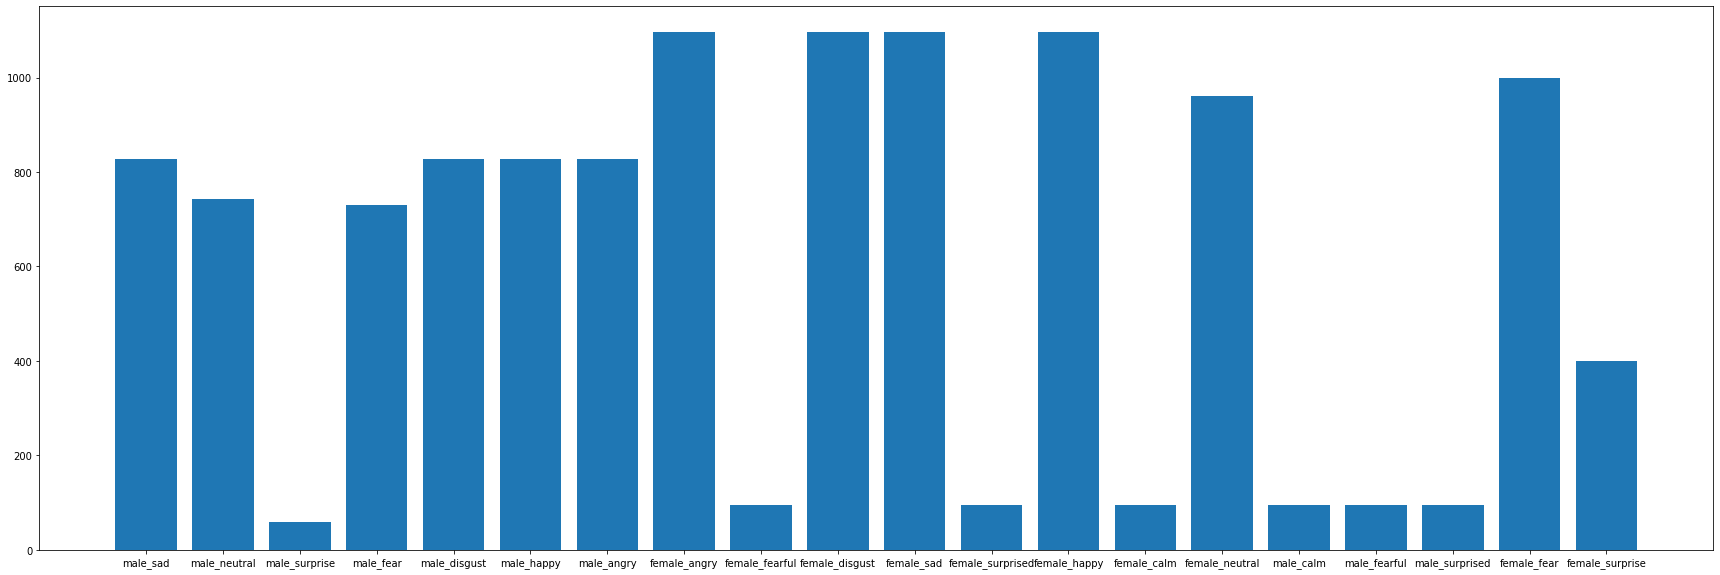

In [885]:
plt.figure(figsize=(30, 10))
plt.bar(categories, count)

In [899]:
np.random.shuffle(combined)
train_index = int(len(combined)*0.8)
train_set_np = combined[:train_index]
test_set_np = combined[train_index:-1]

from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *
import torchvision
import torchvision.transforms as transforms

trainloader = torch.utils.data.DataLoader(train_set_np, shuffle=True, batch_size = 60)
testloader = torch.utils.data.DataLoader(test_set_np, shuffle=False, batch_size = 60)

train = iter(trainloader)
mfcc_data, label = next(train)


In [900]:
print(mfcc_data.view(2, -1).shape)

torch.Size([2, 600])


In [901]:
class Net(nn.Module):
    def __init__ (self):
        super(Net, self).__init__() 
        self.fc1 = nn.Linear(20, 300)
        self.fc2 = nn.Linear(300, 700)
        self.fc3 = nn.Linear(700, 500)
        self.fc4 = nn.Linear(500, 300)
        self.fc5 = nn.Linear(300, 200)
        self.fc6 = nn.Linear(200, 100)
        self.output = nn.Linear(100, 20)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = self.output(x)
        x = self.softmax(x)
        return x
net = Net()   

In [ ]:
import torch.optim as optim
optimizer_nn = optim.Adam(net.parameters(), lr=0.001)
criterion_nn = nn.MSELoss()
losses_nn = []

epochs = 500
for epoch in range(0, epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer_nn.zero_grad()
        outputs = net(inputs)
#         print('Input', inputs.shape)
#         print('Output', outputs.shape)
        labels = labels.type(torch.FloatTensor)
#         print('Labels', labels.shape)
        loss = criterion_nn(outputs, labels)
        loss = Variable(loss, requires_grad=True)
        loss.backward()
        optimizer_nn.step()
        running_loss += loss.item()
        losses_nn.append(loss.item())

    print(f"Epoch: {epoch} Training loss: {running_loss/1}")  


print('Finished Training')

In [32]:
import torch, torch.nn as nn
class LSTM_audio(torch.nn.Module):
    def __init__ (self, audio_dim, hidden_dim):
        super(LSTM_audio, self).__init__()
        self.lstm = nn.LSTM(audio_dim, hidden_dim, batch_first=True) #, bidirectional=True x2 shape
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(hidden_dim, audio_dim)
    def forward(self, x):
        x = self.dropout(x)
#         print((x.view(1, len(x), -1)).shape)
#         print(((x.view(1, len(x), -1)).view(-1, 20)).shape)
        lstm_out, (h_t, c_t) = self.lstm((x.view(1, len(x), -1))) ##lstm output
        model_out = self.output(((x.view(1, len(x), -1)).view(-1, 20))) ##linear layer -> 20 values -> 1 hot vector encoding
        output_pred = F.log_softmax(model_out, dim=0) ##softmax
        return output_pred, (h_t, c_t)

In [ ]:
base_model = label_encoder_dict.copy()
# print(basemodel)
acc_dict = {}
for i in categories:
    key = i
    acc_dict.setdefault(key, [base_model[key].tolist()])

In [ ]:
##LOAD IN NEW MODEL

In [933]:
correct_count, all_count = 0, 0
output_probabilities = []

##STILL NEED TO MAKE CONFUSION MATRIX GRID HERE
    

for i, data in enumerate(trainloader, 0):
    inputs, labels = iter(data)
    with torch.no_grad():
        probs = net(inputs.float())
    ps = torch.exp(probs)
    ps = ps.tolist()
    labels = labels.tolist()
    output_probabilities.append(ps)
    m_pred = max(ps)
    m_true = max(labels)
    if (ps.index(m_pred) == labels.index(m_true)):
        correct_count += 1
    all_count += 1
    
print(correct_count/all_count * 100, '%')

1.8404907975460123 %


Text(0, 0.5, 'loss')

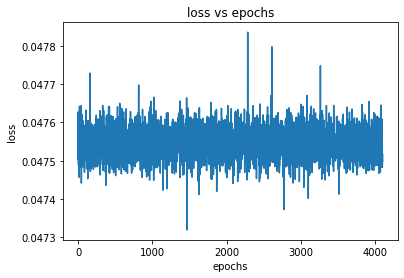

In [931]:
plt.plot(losses_nn)
plt.title('loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
keys = []
values = []
for key, value in label_encoder_dict.items():
    keys.append(key)


In [ ]:
nb_classes = 20
confusion_matrix = np.zeros((nb_classes, nb_classes))
for i, (inputs, classes) in enumerate(testloader):
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t in classes.view(-1):
            for p in preds.view(-1):
                confusion_matrix[t.long(), p.long()] += 1

                
import seaborn as sns

plt.figure(figsize=(15,10))

class_names = keys
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;

## Sentiment Analysis with Text Content Model

In [ ]:
#2. RNN for Text Content Sentiment

class RNN(nn.Module):
    def __init__ (self, input_size, hidden_size, output_size, n_layers = 7):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.input_hidden = nn.Linear(input_size+hidden_size, hidden_size)
        self.input_output = nn.Linear(input_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, inp, hid):
        first = torch.cat((inp, hid), dim=1)
        hidden = self.input_hidden(first)
        output = self.input_hidden(output)
        output = self.input_hidden(output)
        output = self.input_hidden(output)
        output = self.input_hidden(output)
        output = self.input_hidden(output)
        output = self.input_hidden(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

## Training Loop for MFCC and Text Content Models

## Validation and Testing for Sentiment Analaysis

# NLU FOR QUESTION GENERATION SECTION

## Preprocess ALL Data

In [828]:
import nltk

asr_model, decoder, utils = torch.hub.load(repo_or_dir = "snakers4/silero-models", model='silero_stt', language='en', device=torch.device('cpu'))
read_batch, split_into_batch, read_audio, prepare_model_input = utils

pos_tag_model = lambda text: nltk.pos_tag(text)

## load in the primary corpus for ASR 
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

#example audio file
torch.hub.download_url_to_file('https://opus-codec.org/static/examples/samples/speech_orig.wav', dst ='speech_orig.wav', progress=True)
test_files = glob('speech_orig.wav')
batches = split_into_batch(test_files, batch_size=10)

def speech_to_text(input):
    text_format = []
    for example in asr_model(input):
        text_format.append(decoder(example.cpu()))
    return text_format

def text_to_pos(input):
    input = nltk.word_tokenize(str(input).lower())
    pos_tag_model = nltk.pos_tag(input)
    return pos_tag_model

def play_audio(input):
    audio_input, sr = librosa.load(input)
    ipd.Audio(audio_input, rate=sr)

Using cache found in /Users/devpatelio/.cache/torch/hub/snakers4_silero-models_master


In [867]:
print(text_to_pos(train_dataset[0][2]))
print(speech_to_text(train_dataset[0][0]))

[('chapter', 'NN'), ('sixteen', 'NN'), ('i', 'NN'), ('might', 'MD'), ('have', 'VB'), ('told', 'VBN'), ('you', 'PRP'), ('of', 'IN'), ('the', 'DT'), ('beginning', 'NN'), ('of', 'IN'), ('this', 'DT'), ('liaison', 'NN'), ('in', 'IN'), ('a', 'DT'), ('few', 'JJ'), ('lines', 'NNS'), ('but', 'CC'), ('i', 'NN'), ('wanted', 'VBD'), ('you', 'PRP'), ('to', 'TO'), ('see', 'VB'), ('every', 'DT'), ('step', 'NN'), ('by', 'IN'), ('which', 'WDT'), ('we', 'PRP'), ('came', 'VBD'), ('i', 'NN'), ('to', 'TO'), ('agree', 'VB'), ('to', 'TO'), ('whatever', 'VB'), ('marguerite', 'RB'), ('wished', 'JJ')]
['chapterxi i might have told you of the beginning of this sliison in a few lines but i wanted you to see every step by which we came i too agree to whatever marguerite wished']
